In [1]:
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import svm
import time
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,\
    precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import time
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', None)
games = pd.read_csv('data/full_data.csv',index_col=0)

In [3]:
games

,season,Week,home_pts,away_pts,total_pts,home_win,Day,Time,home_abbr,away_abbr,PointSpread,OverUnder,AwayTeamMoneyLine,HomeTeamMoneyLine,home_fav,date_match,DST1_away,DST1_home,QB1_away,QB1_home,RB1_away,RB1_home,RB2_away,RB2_home,WR1_away,WR1_home,WR2_away,WR2_home,WR3_away,WR3_home,WR4_away,WR4_home,TE1_away,TE1_home,TE2_away,TE2_home
0,2016,1,21.0,20.0,41.0,1,Thu,8:40PM,DEN,CAR,-3.0,41.0,-165,145,False,2016-09-08,3800.0,3700.0,7700.0,5200.0,5100.0,5900.0,3000.0,3300.0,5700.0,7000.0,4100.0,5700.0,3000.0,3000.0,3000.0,3000.0,5100.0,2900.0,4800.0,2500.0
1,2016,1,13.0,7.0,20.0,1,Sun,1:04PM,BAL,BUF,-3.0,45.0,130,-150,True,2016-09-11,2900.0,2700.0,6900.0,6700.0,6400.0,4600.0,3800.0,4100.0,6900.0,4900.0,4600.0,4700.0,3300.0,4200.0,3000.0,3700.0,3400.0,3500.0,2500.0,3000.0
2,2016,1,23.0,27.0,50.0,0,Sun,1:04PM,JAX,GB,-6.0,48.0,-210,175,False,2016-09-11,2800.0,2400.0,8500.0,7200.0,6700.0,4300.0,4800.0,4100.0,7700.0,8300.0,7600.0,5800.0,4300.0,3500.0,3700.0,3100.0,3100.0,3800.0,2900.0,2700.0
3,2016,1,24.0,31.0,55.0,0,Sun,1:05PM,ATL,TB,-3.0,47.0,115,-135,True,2016-09-11,2600.0,2800.0,6600.0,7100.0,6200.0,6900.0,4400.0,4200.0,7400.0,9400.0,4400.0,5100.0,3400.0,3100.0,3300.0,3000.0,2900.0,2800.0,2800.0,2500.0
4,2016,1,23.0,14.0,37.0,1,Sun,1:05PM,HOU,CHI,-6.0,42.5,220,-260,True,2016-09-11,2500.0,3200.0,6300.0,6300.0,4700.0,7000.0,3700.0,3600.0,7900.0,8800.0,5200.0,3800.0,3700.0,3700.0,3200.0,3000.0,3700.0,2600.0,2500.0,2500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2022,13,NaN,NaN,NaN,0,Sun,4:05PM,SF,MIA,-4.5,45.5,180,-217,True,2022-12-04,2500.0,3100.0,6700.0,5700.0,6100.0,8600.0,5500.0,4800.0,8800.0,6600.0,7400.0,6100.0,3300.0,3200.0,3000.0,3000.0,3300.0,5000.0,2600.0,2600.0
1743,2022,13,NaN,NaN,NaN,0,Sun,4:25PM,LV,LAC,-2.5,49.5,115,-136,True,2022-12-04,3400.0,2500.0,7200.0,5600.0,8500.0,7900.0,4200.0,4600.0,6500.0,8700.0,5900.0,4600.0,5600.0,4100.0,3900.0,3000.0,4400.0,4500.0,2500.0,3600.0
1744,2022,13,NaN,NaN,NaN,0,Sun,4:25PM,CIN,KC,-2.0,52.5,-134,113,False,2022-12-04,3500.0,2400.0,8300.0,6900.0,5700.0,7100.0,4500.0,6000.0,5700.0,7900.0,4900.0,7200.0,4400.0,5300.0,4100.0,3000.0,7900.0,3500.0,2700.0,2500.0
1745,2022,13,NaN,NaN,NaN,0,Sun,8:20PM,DAL,IND,-10.5,44.0,394,-513,True,2022-12-04,2300.0,3900.0,5200.0,6200.0,7700.0,6500.0,5300.0,5800.0,6100.0,7300.0,4600.0,4600.0,3700.0,3400.0,3000.0,3000.0,2800.0,4100.0,2600.0,2700.0


In [4]:
games_2022 = games.loc[(games['season'] == 2022) & (games['Week'] != 13)]
games_dev = games.loc[games['season'] != 2022]
games_dev.dropna(subset=['QB1_home'], axis = 0, inplace = True)

C:\Users\binga\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [5]:
#create aggregations of offensive salaries for home, away, and total
away_offense = ['QB1_away','RB1_away','RB2_away', 'WR1_away', 'WR2_away','WR3_away', 'WR4_away', 'TE1_away','TE2_away']
home_offense = ['QB1_home','RB1_home', 'RB2_home', 'WR1_home','WR2_home', 'WR3_home', 'WR4_home','TE1_home', 'TE2_home']
games['away_off_total'] = games.filter(away_offense).sum(axis = 1)
games['home_off_total'] = games.filter(away_offense).sum(axis = 1)
games['total_offense_sal'] = games['away_off_total'] + games['home_off_total']

In [6]:
pred_cols = ['DST1_away', 'DST1_home', 'QB1_away', 'QB1_home', 'RB1_away',
       'RB1_home', 'RB2_away', 'RB2_home', 'WR1_away', 'WR1_home', 'WR2_away',
       'WR2_home', 'WR3_away', 'WR3_home', 'WR4_away', 'WR4_home', 'TE1_away','away_off_total','home_off_total',
       'total_offense_sal','TE1_home', 'TE2_away', 'TE2_home','PointSpread','AwayTeamMoneyLine','HomeTeamMoneyLine','OverUnder']

In [7]:
games_2022

,season,Week,home_pts,away_pts,total_pts,home_win,Day,Time,home_abbr,away_abbr,PointSpread,OverUnder,AwayTeamMoneyLine,HomeTeamMoneyLine,home_fav,date_match,DST1_away,DST1_home,QB1_away,QB1_home,RB1_away,RB1_home,RB2_away,RB2_home,WR1_away,WR1_home,WR2_away,WR2_home,WR3_away,WR3_home,WR4_away,WR4_home,TE1_away,TE1_home,TE2_away,TE2_home
1552,2022,1,10.0,31.0,41.0,0,Thu,8:20PM,LAR,BUF,-1.5,52.0,-130,109,False,2022-09-08,3200.0,3100.0,7800.0,6200.0,5800.0,5900.0,4400.0,5300.0,7200.0,8500.0,5800.0,6100.0,4400.0,3500.0,4400.0,3000.0,4400.0,3800.0,2500.0,2500.0
1553,2022,1,26.0,27.0,53.0,0,Sun,1:00PM,ATL,NO,-5.5,44.0,-240,199,False,2022-09-11,3700.0,2800.0,5300.0,5200.0,7600.0,5800.0,5900.0,4700.0,5700.0,5000.0,5000.0,4200.0,4500.0,4000.0,4300.0,3500.0,4600.0,5700.0,3100.0,4000.0
1554,2022,1,24.0,26.0,50.0,0,Sun,1:00PM,CAR,CLE,-1.5,41.5,105,-124,True,2022-09-11,3800.0,3400.0,6600.0,5300.0,6500.0,8500.0,5700.0,5400.0,5900.0,6000.0,4400.0,4800.0,3600.0,4300.0,3300.0,3900.0,3900.0,4000.0,2900.0,3100.0
1555,2022,1,19.0,10.0,29.0,1,Sun,1:00PM,CHI,SF,-6.5,37.5,-281,229,False,2022-09-11,4100.0,2200.0,6000.0,5600.0,5400.0,6000.0,5100.0,5200.0,7400.0,5700.0,5200.0,4400.0,3200.0,3600.0,3100.0,3000.0,5900.0,3700.0,2700.0,2700.0
1556,2022,1,20.0,23.0,43.0,0,Sun,1:00PM,CIN,PIT,-7.0,44.5,255,-321,True,2022-09-11,2400.0,3600.0,5000.0,6400.0,6400.0,7100.0,4800.0,5000.0,6000.0,7100.0,5000.0,6100.0,4100.0,4800.0,3200.0,3000.0,4200.0,3300.0,2800.0,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,2022,12,24.0,25.0,49.0,0,Sun,4:05PM,ARI,LAC,-2.5,48.5,-146,123,False,2022-11-27,3300.0,2700.0,7000.0,6800.0,8500.0,6600.0,4200.0,4800.0,6300.0,7700.0,6100.0,5300.0,5400.0,5100.0,3700.0,3400.0,4400.0,3100.0,2800.0,2500.0
1728,2022,12,26.0,10.0,36.0,1,Sun,4:25PM,KC,LAR,-16.5,41.5,785,-1299,True,2022-11-27,2300.0,2800.0,5300.0,8200.0,4900.0,5500.0,4900.0,4700.0,8000.0,5700.0,5500.0,4900.0,4500.0,4500.0,3400.0,4000.0,4200.0,7700.0,2500.0,2800.0
1729,2022,12,13.0,0.0,13.0,1,Sun,4:25PM,SF,NO,-8.5,43.5,320,-409,True,2022-11-27,2400.0,4000.0,5300.0,5600.0,7300.0,8800.0,5000.0,4900.0,6600.0,6800.0,4400.0,6400.0,3300.0,3100.0,3000.0,3000.0,4800.0,5300.0,3400.0,2700.0
1730,2022,12,40.0,33.0,73.0,1,Sun,8:20PM,PHI,GB,-6.5,46.0,233,-288,True,2022-11-27,2200.0,3400.0,5800.0,8100.0,7100.0,6300.0,5200.0,5000.0,5800.0,7500.0,5000.0,6100.0,4800.0,3500.0,3900.0,3200.0,3300.0,4900.0,2600.0,2500.0


In [8]:
x_train, x_test, y_train, y_test = train_test_split(games_dev.filter(pred_cols).fillna(0),games_dev['home_win'], test_size=0.25, random_state=44)

In [9]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [10]:
random_state = 44

In [11]:
def plot_and_get_metrics(clf):
    preds_pp = cross_val_predict(clf, x_train, y_train, cv=5, method='predict_proba')[:,1]
    preds = preds_pp.round()
    print(classification_report(y_train, preds))

    clf_cv_acc = accuracy_score(y_train, preds)
    clf_cv_prec = precision_score(y_train, preds)
    clf_cv_recall = recall_score(y_train, preds)
    clf_cv_auc = roc_auc_score(y_train, preds)

    cm = confusion_matrix(y_train, preds, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

    return preds_pp, preds, clf_cv_acc, clf_cv_prec, clf_cv_recall, clf_cv_auc

In [12]:
def plot_and_get_metrics_scaled(clf):
    preds_pp = cross_val_predict(clf, x_train_scaled, y_train, cv=5, method='predict_proba')[:,1]
    preds = preds_pp.round()
    print(classification_report(y_train, preds))

    clf_cv_acc = accuracy_score(y_train, preds)
    clf_cv_prec = precision_score(y_train, preds)
    clf_cv_recall = recall_score(y_train, preds)
    clf_cv_auc = roc_auc_score(y_train, preds)

    cm = confusion_matrix(y_train, preds, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

    return preds_pp, preds, clf_cv_acc, clf_cv_prec, clf_cv_recall, clf_cv_auc

### KNN 

In [13]:
knn = KNeighborsClassifier()
start_time = time.time()
param_grid = {
    'n_neighbors' : [num for num in range(2,34)],
    'weights' : ['uniform','distance'],
    'p': [1,2],
    'n_jobs': [-1]
}

knn_grid = GridSearchCV(knn, param_grid, scoring='balanced_accuracy', n_jobs=-1)
knn_grid.fit(x_train, y_train)
best_knn = knn_grid.best_estimator_
print(time.time() - start_time)
best_knn

7.354233503341675


KNeighborsClassifier(n_jobs=-1, n_neighbors=18, p=1)

              precision    recall  f1-score   support

           0       0.61      0.65      0.63       537
           1       0.68      0.65      0.66       622

    accuracy                           0.65      1159
   macro avg       0.65      0.65      0.65      1159
weighted avg       0.65      0.65      0.65      1159



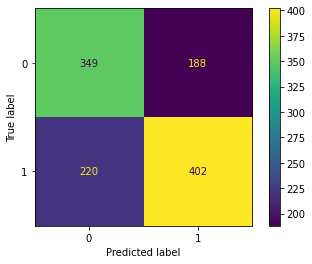

In [14]:
knn_run = KNeighborsClassifier(n_jobs=-1, n_neighbors=18, p=1)
best_knn = knn_run.fit(x_train,y_train)
knn_preds_pp, knn_preds, knn_cv_acc, knn_cv_prec, knn_cv_recall, knn_cv_auc = plot_and_get_metrics(best_knn)

### One Class SVM 

In [15]:
x_train_home_w = x_train[y_train == 1]

In [16]:
one_cl_svm = svm.OneClassSVM(kernel = 'poly', gamma = 50)
one_cl_svm.fit(x_train_home_w)

OneClassSVM(gamma=50, kernel='poly')

In [17]:
one_cl_svm_pred = np.where(one_cl_svm.predict(x_test) == -1,0,one_cl_svm.predict(x_test))

In [18]:
1-(np.equal(one_cl_svm_pred,y_test).sum()/len(y_test))

0.5503875968992248

In [19]:
gamma_vals = np.arange(0.1,5.0,0.1)
svm_misclass_rates = []
for x in range(len(gamma_vals)):
    svm_clf = svm.OneClassSVM(kernel = 'poly', coef0 = gamma_vals[x])
    svm_clf.fit(x_train_home_w)
    svm_pred = svm_clf.predict(x_test)
    svm_pred = np.where(svm_pred == -1,0,svm_pred)
    svm_misclass_rates.append(1-(np.equal(svm_pred,y_test).sum()/len(y_test)))

In [20]:
def svm_plot():
    plt.figure(figsize=(15,5))
    plt.plot(gamma_vals,svm_misclass_rates, label ='One Class SVM Misclassification Rate')
    plt.ylabel("Misclassification rate")
    plt.title("Misclassification Rate for Gamma Values in One Class SVM")
    plt.legend()
    plt.xlabel("Gamma")
    plt.show()

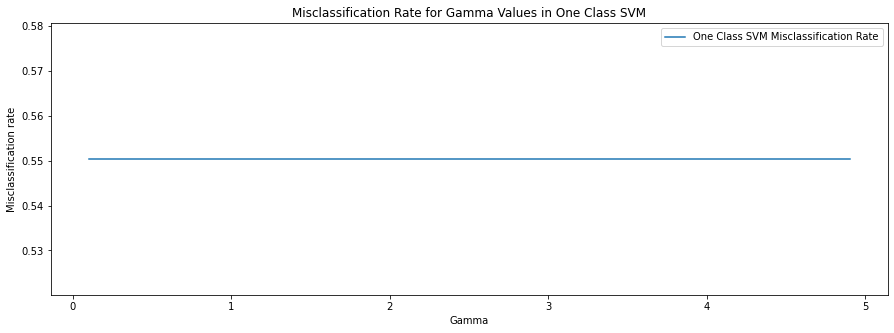

In [21]:
svm_plot()

### Naive Bayes

              precision    recall  f1-score   support

           0       0.63      0.64      0.64       537
           1       0.69      0.68      0.68       622

    accuracy                           0.66      1159
   macro avg       0.66      0.66      0.66      1159
weighted avg       0.66      0.66      0.66      1159



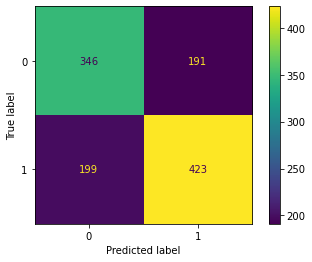

In [22]:
run_nb = GaussianNB()
run_nb.fit(x_train,y_train)
best_nb = run_nb
nb_preds_pp, nb_preds, nb_cv_acc, nb_cv_prec, nb_cv_recall, nb_cv_auc = plot_and_get_metrics(run_nb)

### SVM

In [23]:
svm = SVC(probability = True, random_state = random_state, max_iter = -1)
start_time = time.time()
param_grid = {
    'C' : [1,1.2,1.3,1.5,1.65,1.8,2],
    'kernel' : ['poly','rbf','linear'],
    'degree': [2,3],
}

svm_grid = GridSearchCV(svm, param_grid, scoring='balanced_accuracy', n_jobs=-1)
svm_grid.fit(x_train_scaled, y_train)
best_svm = svm_grid.best_estimator_
print(time.time() - start_time)
best_svm

23.64890480041504


SVC(C=1.5, degree=2, kernel='linear', probability=True, random_state=44)

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       537
           1       0.68      0.74      0.71       622

    accuracy                           0.67      1159
   macro avg       0.67      0.67      0.67      1159
weighted avg       0.67      0.67      0.67      1159



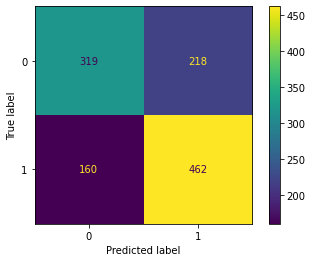

In [24]:
run_svm = SVC(C=1.2, degree=2, kernel='linear', probability=True, random_state=44)
svm_preds_pp, svm_preds, svm_cv_acc, svm_cv_prec, svm_cv_recall, svm_cv_auc = plot_and_get_metrics_scaled(best_svm)

### Random Forest

In [25]:
start_time = time.time()
rf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
param_grid = {
    'n_estimators': [150,200,250],
    'criterion': ['entropy', 'gini'],
    'min_samples_leaf': [x for x in range(2,7)],
    'max_depth': [5,10,15,20],
    'bootstrap': [True]
}
rf_clf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
rf_clf.fit(x_train, y_train)
best_rf = rf_clf.best_estimator_
print(round((time.time() - start_time)/60, 2))
best_rf

1.57


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_leaf=2, n_estimators=150,
                       random_state=44)

              precision    recall  f1-score   support

           0       0.64      0.66      0.65       537
           1       0.70      0.68      0.69       622

    accuracy                           0.67      1159
   macro avg       0.67      0.67      0.67      1159
weighted avg       0.67      0.67      0.67      1159



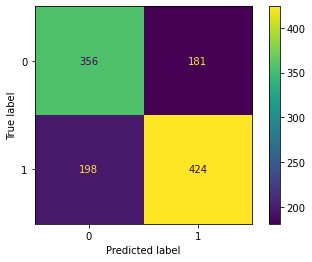

In [26]:
rf_run = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=6, n_estimators=250,
                       random_state=44)
rf_preds_pp, rf_preds, rf_cv_acc, rf_cv_prec, rf_cv_recall, rf_cv_auc = plot_and_get_metrics(best_rf)

### Light GBM

In [27]:
start_time = time.time()
lgbmc = lgb.LGBMClassifier(class_weight='balanced', random_state=random_state)

param_grid = {
    'max_depth': [5,10,15,20],
    # 'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01, 0.025],
    'n_estimators': [150, 200, 250],
    # 'feature_fraction': [0.5],
    'min_child_samples': [x for x in range(2,5)],
    'reg_alpha': [0.1, 0.5,1,1.5],
    'reg_lambda': [0.1, 0.5,1,1.5]
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring='accuracy',
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

lgbmc_clf.fit(x_train, y_train)
best_lgb = lgbmc_clf.best_estimator_
print(round((time.time() - start_time)/60, 2))
best_lgb

9.46


LGBMClassifier(class_weight='balanced', learning_rate=0.025, max_depth=5,
               min_child_samples=4, n_estimators=250, random_state=44,
               reg_alpha=0.5, reg_lambda=0.5)

In [28]:
lgbm_run = lgb.LGBMClassifier(class_weight='balanced', learning_rate=0.025, max_depth=10,
               min_child_samples=2, n_estimators=200, random_state=44,
               reg_alpha=0.1, reg_lambda=0.5)
best_lgb = lgbm_run.fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.61      0.62      0.62       537
           1       0.67      0.66      0.67       622

    accuracy                           0.64      1159
   macro avg       0.64      0.64      0.64      1159
weighted avg       0.64      0.64      0.64      1159



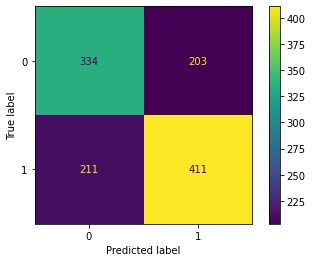

In [29]:
lgb_preds_pp, lgb_preds, lgb_cv_acc, lgb_cv_prec, lgb_cv_recall, lgb_cv_auc = plot_and_get_metrics(best_lgb)

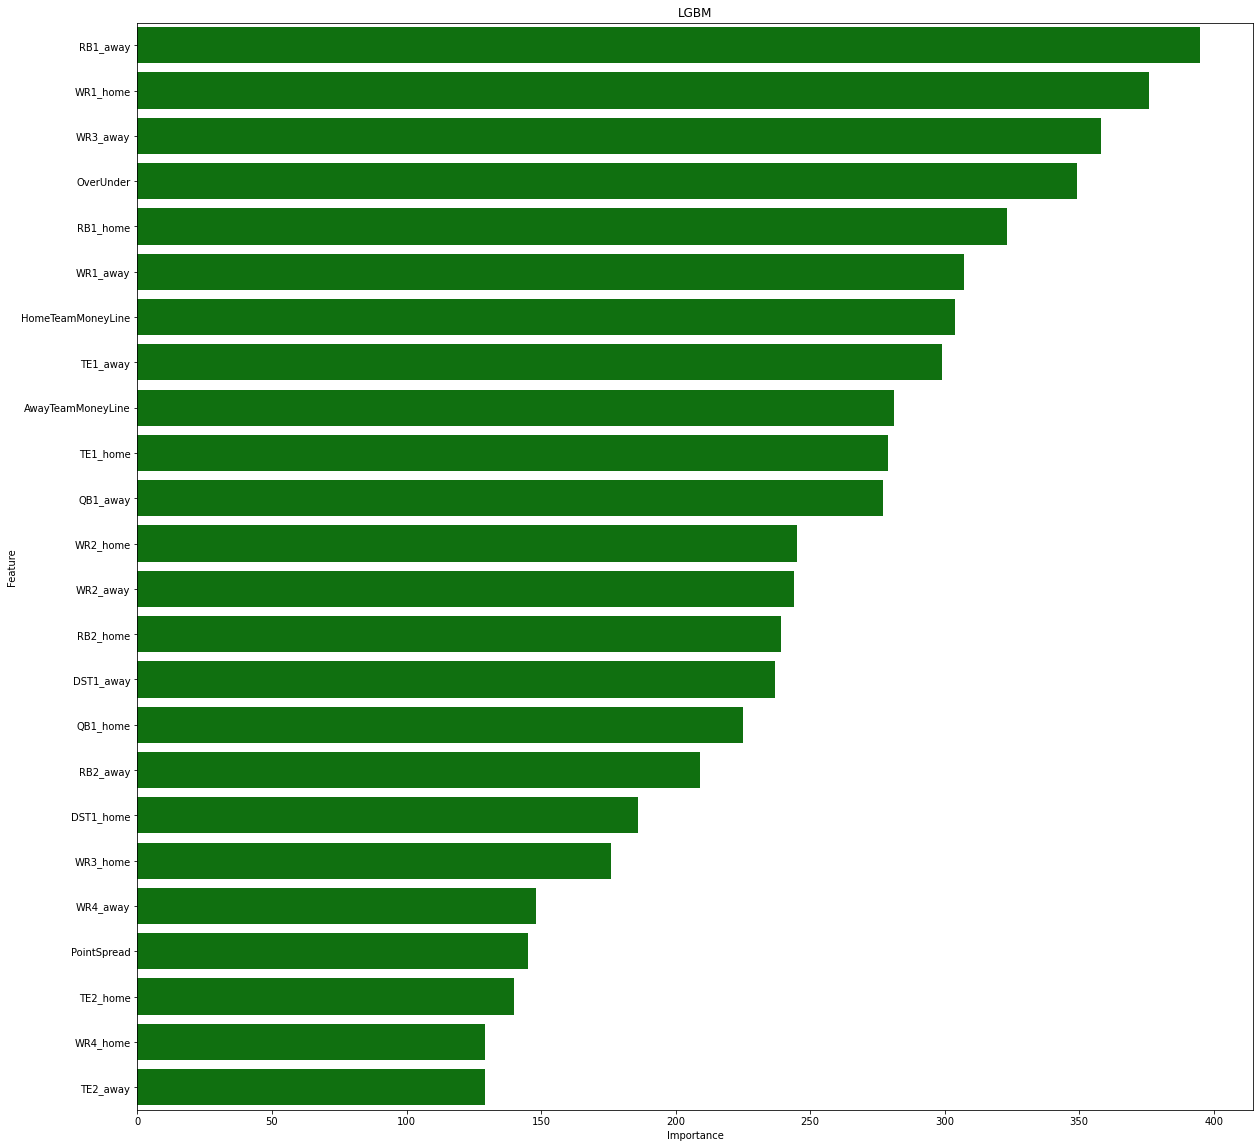

In [32]:
plt.figure(figsize=(20,20))
sns.barplot(data=pd.DataFrame({'Feature': x_train.columns, 'Importance': best_lgb.feature_importances_}).\
    sort_values('Importance', ascending=False), x='Importance', y='Feature', color='g').set_title('LGBM')
plt.savefig('feat_import_LGBM.png')

### XGBoost

In [33]:
import warnings
warnings.filterwarnings("ignore")
xgb = XGBClassifier(scale_pos_weight=4, random_state=random_state)
start_time = time.time()
param_grid = {
    'n_estimators': [150,250,500],
    'learning_rate': [0.025,0.05,0.1],
    'max_depth': [15,20,25],
    'subsample': [0.5, 0.75],
    'alpha': [0.1,1,1.5],
    'lambda': [0.5,1,5]
}

xgb_clf = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', n_jobs=-1)

xgb_clf.fit(x_train, y_train)
best_xgb = xgb_clf.best_estimator_
print((time.time() - start_time)/60)
best_xgb

[22:06:33] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
23.867789208889008


XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', lambda=1, learning_rate=0.1,
              max_delta_step=0, max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0.100000001, reg_lambda=1, scale_pos_weight=4,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [34]:
xgb_run = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='error', gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.025, max_delta_step=0, max_depth=25,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=44, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              subsample=0.75, tree_method='exact', validate_parameters=1,
              verbosity=None)
best_xgb = xgb_run.fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.66      0.42      0.52       537
           1       0.62      0.82      0.71       622

    accuracy                           0.63      1159
   macro avg       0.64      0.62      0.61      1159
weighted avg       0.64      0.63      0.62      1159



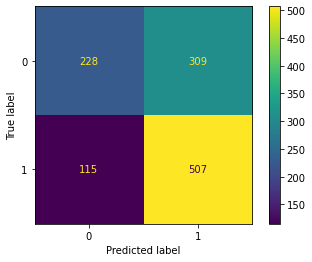

In [35]:
xgb_preds_pp, xgb_preds, xgb_cv_acc, xgb_cv_prec, xgb_cv_recall, xgb_cv_auc = plot_and_get_metrics(best_xgb)

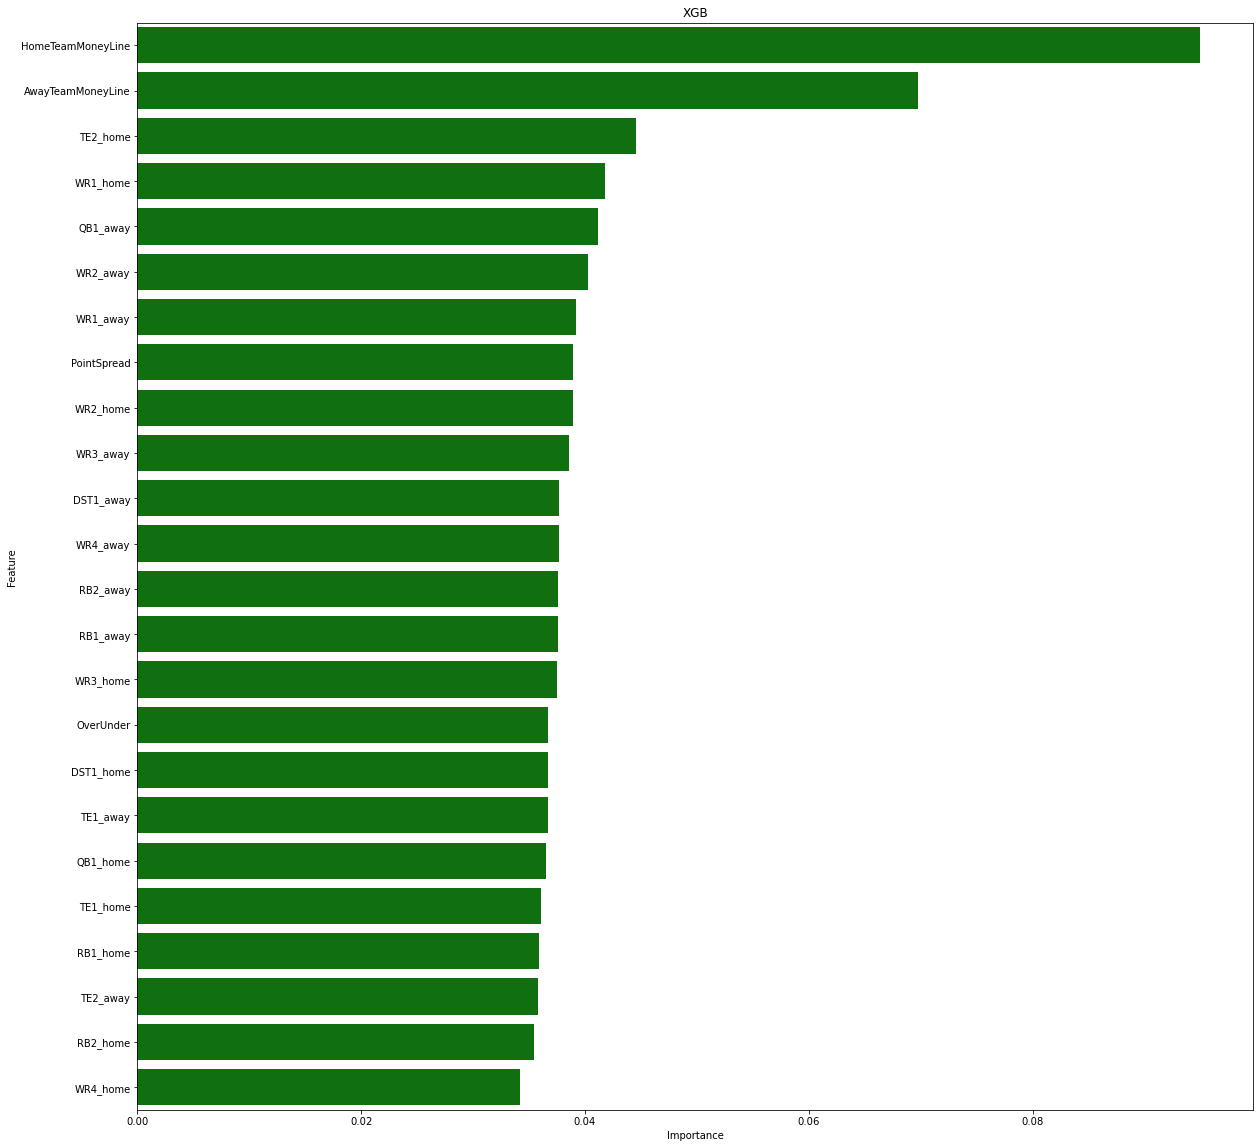

In [36]:
plt.figure(figsize=(20,20))
sns.barplot(data=pd.DataFrame({'Feature': x_train.columns, 'Importance': best_xgb.feature_importances_}).\
    sort_values('Importance', ascending=False), x='Importance', y='Feature', color='g').set_title('XGB')
plt.savefig('feat_import_xgb.png')

In [37]:
model_names = ['XGB', 'LGBM', 'RF',  'KNN', 'SVM','NB']
cv_accuracy = pd.Series([xgb_cv_acc, lgb_cv_acc, rf_cv_acc, knn_cv_acc, svm_cv_acc, nb_cv_acc], name='Accuracy')
cv_recall = pd.Series([xgb_cv_recall, lgb_cv_recall, rf_cv_recall, knn_cv_recall, svm_cv_recall, nb_cv_recall], name='Recall')
cv_precision = pd.Series([xgb_cv_prec, lgb_cv_prec, rf_cv_prec, knn_cv_prec, svm_cv_prec, nb_cv_prec],name='Precision')
cv_auc = pd.Series([xgb_cv_auc, lgb_cv_auc, rf_cv_auc,  knn_cv_auc, svm_cv_auc, nb_cv_auc], name='AUC')

In [38]:
scores_summary = pd.concat([cv_accuracy, cv_recall, cv_precision, cv_auc], axis=1)
scores_summary.columns = ['Accuracy', 'Recall', 'Precision', 'AUC']
scores_summary.index = model_names
scores_summary.style.highlight_max(color='green', axis=0)

,Accuracy,Recall,Precision,AUC
XGB,0.634167,0.815113,0.621324,0.619847
LGBM,0.642796,0.660772,0.669381,0.641373
RF,0.672994,0.681672,0.700826,0.672307
KNN,0.647972,0.646302,0.681356,0.648105
SVM,0.673857,0.742765,0.679412,0.668403
NB,0.663503,0.680064,0.688925,0.662192


In [39]:
comp_df = pd.DataFrame({'true': y_train, 'knn_preds_pp': knn_preds_pp, 'rf_preds_pp': rf_preds_pp,\
                        'lgb_preds_pp':lgb_preds_pp,'xgb_preds_pp':xgb_preds_pp ,'nb_preds_pp':nb_preds_pp,\
                        'svm_preds_pp': svm_preds_pp,'home_ML': x_train['HomeTeamMoneyLine'],\
                        'away_ML': x_train['AwayTeamMoneyLine']
                        })
comp_df['vegas_home_prob'] = np.where(comp_df['home_ML'] < 0, abs(comp_df['home_ML'])/(abs(comp_df['home_ML'])+100), 100/(comp_df['home_ML']+100))
comp_df['vegas_away_prob'] = np.where(comp_df['away_ML'] < 0, abs(comp_df['away_ML'])/(abs(comp_df['away_ML'])+100), 100/(comp_df['away_ML']+100))
comp_df.head()

,true,knn_preds_pp,rf_preds_pp,lgb_preds_pp,xgb_preds_pp,nb_preds_pp,svm_preds_pp,home_ML,away_ML,vegas_home_prob,vegas_away_prob
1524,0,0.611111,0.727100,0.782526,0.908619,0.653586,0.740587,-385,304,0.793814,0.247525
218,1,0.722222,0.780644,0.825327,0.935778,1.000000,0.824761,-1100,700,0.916667,0.125000
1039,0,0.500000,0.454908,0.586433,0.728541,0.308748,0.378285,149,-182,0.401606,0.645390
1229,0,0.722222,0.517015,0.480662,0.743682,0.848523,0.610664,-150,127,0.600000,0.440529
61,1,0.555556,0.549158,0.731565,0.521176,0.905527,0.572536,-180,150,0.642857,0.400000


Only bet when our model probability is higher than Vegas' implied probability. If both higher than Vegas, take the one with higher margin.

In [40]:
def away_return(df):
    if (df['bet_away'] and (df['true'] == 1)):
        return -100
    elif (df['bet_away'] and (df['away_ML']>0) and (df['true'] == 0)):
        return df['away_ML']
    elif (df['bet_away'] and (df['away_ML']<0) & (df['true'] == 0)):
        return round((100/df['away_ML'])*-100,2)
    else: 
        return 0
    
def home_return(df):
    if (df['bet_home'] and (df['true'] == 0)):
        return -100
    elif (df['bet_home'] and (df['home_ML']>0) and (df['true'] == 1)):
        return df['home_ML']
    elif (df['bet_home'] and (df['home_ML']<0) & (df['true'] == 1)):
        return round((100/df['home_ML'])*-100,2)
    else: 
        return 0
def pred_vs_vegas(model_preds, comp, margin = 0):
    '''
    
    :param margin: margin between our predictions and vegas predictions to trigger making a bet (example: 0.05)
    :param comp: comparison dataframe to use for function (train or test predictions)
    :param model_preds: model column name of prediction probability
    :return:% return, $ risked, total $ returned
    '''
    #create working dataframe
    df_w = comp[['true',model_preds,'home_ML','away_ML','vegas_home_prob','vegas_away_prob']]
    
    #calculate differential of our predictions vs vegas' implied probability
    df_w['home_prob_adv'] = df_w[model_preds] - df_w['vegas_home_prob']
    df_w['away_prob_adv'] = (1-df_w[model_preds]) - df_w['vegas_away_prob']
    
    #flag whether the home differential is higher than the away differential
    df_w['home_adv_higher'] = df_w['home_prob_adv'] > df_w['away_prob_adv']
    
    #flag whether to bet on the home or away team
    df_w['bet_home'] = np.where((df_w['home_adv_higher'] & (df_w['home_prob_adv']>margin)), True, False)
    df_w['bet_away'] = np.where(((df_w['bet_home'] == False) & (df_w['away_prob_adv']>margin)), True, False)
    
    #generate bet returns
    df_w['home_risk'] = np.where(df_w['bet_home'], 100, 0)
    df_w['away_risk'] = np.where(df_w['bet_away'], 100, 0)
    df_w['away_return'] = df_w.apply(away_return, axis = 1)
    df_w['home_return'] = df_w.apply(home_return, axis = 1)
    
    #aggregate risks and returns
    df_w['risk'] = df_w['home_risk'] + df_w['away_risk']
    df_w['return'] = df_w['home_return'] + df_w['away_return']
    
    return df_w

def aggregate_returns(df_w):
    return df_w['risk'].sum(),df_w['return'].sum(),(df_w['return'].sum()/df_w['risk'].sum())

In [41]:
final_models = ['knn_preds_pp','svm_preds_pp','nb_preds_pp','rf_preds_pp','xgb_preds_pp','lgb_preds_pp']

In [42]:
mod_risk = []
mod_ret = []
mod_pct_ret = []
models = []
margins = []
for model in final_models:
    for margin in np.arange(0,.2,0.01):
        df = pred_vs_vegas(model,comp_df,margin)
        risk, ret, pct = aggregate_returns(df)
        mod_risk.append(risk)
        mod_ret.append(ret)
        mod_pct_ret.append(pct)
        models.append(model)
        margins.append(margin)

higher_exp_val_df = pd.DataFrame({'model':models,'margin': margins, 'pct_ret': mod_pct_ret, 'risked':mod_risk, 'dollar_ret':mod_ret})

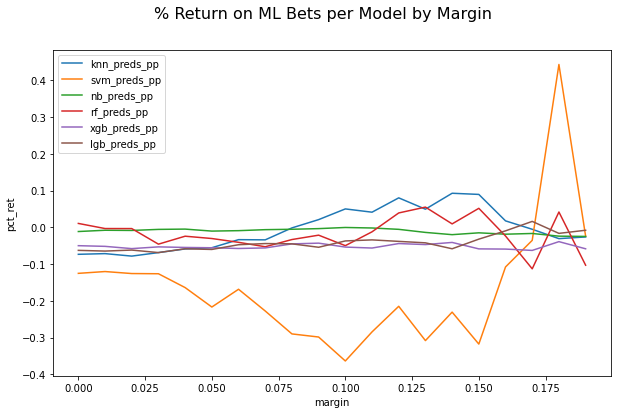

In [49]:
plt.figure(figsize=(10,6))
sns.lineplot(x='margin', y='pct_ret', hue='model', data=higher_exp_val_df)
plt.suptitle('% Return on ML Bets per Model by Margin', size=16)
plt.legend(loc='upper left')
plt.savefig('strat_3_ret.png')

In [54]:
higher_exp_val_df.loc[higher_exp_val_df['model'] == 'rf_preds_pp']

,model,margin,pct_ret,risked,dollar_ret
60,rf_preds_pp,0.00,0.010822,98800,1069.19
61,rf_preds_pp,0.01,-0.003114,88900,-276.85
62,rf_preds_pp,0.02,-0.003199,78700,-251.76
63,rf_preds_pp,0.03,-0.045611,69800,-3183.68
64,rf_preds_pp,0.04,-0.023956,61600,-1475.66
65,rf_preds_pp,0.05,-0.030273,53200,-1610.51
66,rf_preds_pp,0.06,-0.040603,46300,-1879.90
67,rf_preds_pp,0.07,-0.052671,38300,-2017.29
68,rf_preds_pp,0.08,-0.033030,32600,-1076.78
69,rf_preds_pp,0.09,-0.021130,26000,-549.38


In [45]:
comp_df2 = pd.DataFrame({'true': games_2022['home_win'], 'knn_preds_pp': best_knn.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'rf_preds_pp': best_rf.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'lgb_preds_pp':best_lgb.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'xgb_preds_pp':best_xgb.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'nb_preds_pp':best_nb.predict_proba(games_2022.filter(pred_cols).fillna(0))[:,1],\
                        'svm_preds_pp':best_svm.predict_proba(scaler.transform(games_2022.filter(pred_cols).fillna(0)))[:,1],\
                        'home_ML': games_2022['HomeTeamMoneyLine'], 'away_ML': games_2022['AwayTeamMoneyLine']
                        })
comp_df2['vegas_home_prob'] = np.where(comp_df2['home_ML'] < 0, abs(comp_df2['home_ML'])/(abs(comp_df2['home_ML'])+100), 100/(comp_df2['home_ML']+100))
comp_df2['vegas_away_prob'] = np.where(comp_df2['away_ML'] < 0, abs(comp_df2['away_ML'])/(abs(comp_df2['away_ML'])+100), 100/(comp_df2['away_ML']+100))
comp_df2.head()

,true,knn_preds_pp,rf_preds_pp,lgb_preds_pp,xgb_preds_pp,nb_preds_pp,svm_preds_pp,home_ML,away_ML,vegas_home_prob,vegas_away_prob
1552,0,0.611111,0.448983,0.554664,0.808429,0.113006,0.425005,109,-130,0.478469,0.565217
1553,0,0.444444,0.326760,0.331682,0.274078,0.048327,0.320614,199,-240,0.334448,0.705882
1554,0,0.444444,0.430881,0.496473,0.624065,0.236285,0.570964,-124,105,0.553571,0.487805
1555,1,0.388889,0.196620,0.103749,0.083245,0.004784,0.274847,229,-281,0.303951,0.737533
1556,0,0.722222,0.841345,0.916689,0.981228,0.988300,0.650365,-321,255,0.762470,0.281690


In [46]:
mod_risk = []
mod_ret = []
mod_pct_ret = []
models = []
margins = []
for model in final_models:
    for margin in np.arange(0,.2,0.01):
        df = pred_vs_vegas(model,comp_df2,margin)
        risk, ret, pct = aggregate_returns(df)
        mod_risk.append(risk)
        mod_ret.append(ret)
        mod_pct_ret.append(pct)
        models.append(model)
        margins.append(margin)

higher_exp_val_df2 = pd.DataFrame({'model':models,'margin': margins, 'pct_ret': mod_pct_ret, 'risked':mod_risk, 'dollar_ret':mod_ret})

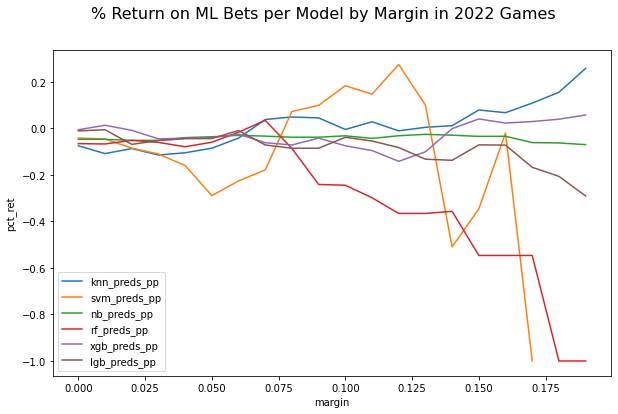

In [47]:
plt.figure(figsize=(10,6))
sns.lineplot(x='margin', y='pct_ret', hue='model', data=higher_exp_val_df2)
plt.suptitle('% Return on ML Bets per Model by Margin in 2022 Games', size=16)
plt.legend(loc='lower left')
plt.savefig('strat_3_ret.png')

In [53]:
higher_exp_val_df2.loc[higher_exp_val_df2['model'] == 'rf_preds_pp']

,model,margin,pct_ret,risked,dollar_ret
60,rf_preds_pp,0.00,-0.065520,14100,-923.83
61,rf_preds_pp,0.01,-0.067021,12400,-831.06
62,rf_preds_pp,0.02,-0.051487,11200,-576.65
63,rf_preds_pp,0.03,-0.060362,9200,-555.33
64,rf_preds_pp,0.04,-0.078785,8000,-630.28
65,rf_preds_pp,0.05,-0.059597,7400,-441.02
66,rf_preds_pp,0.06,-0.016380,5900,-96.64
67,rf_preds_pp,0.07,0.034357,4900,168.35
68,rf_preds_pp,0.08,-0.086324,3700,-319.40
69,rf_preds_pp,0.09,-0.241038,2400,-578.49
